In [1]:
import torch


def batch_symeig(mat):
    """
    """
    mat_orig = mat
    batch_shape = torch.Size(mat_orig.shape[:-2])
    matrix_shape = torch.Size(mat_orig.shape[-2:])

    # Smaller matrices are faster on the CPU than the GPU
    if mat.size(-1) <= 32:
        mat = mat.cpu()

    mat = mat.view(-1, *matrix_shape)
    eigenvectors = torch.empty(batch_shape.numel(), *matrix_shape, dtype=mat.dtype, device=mat.device)
    eigenvalues = torch.empty(batch_shape.numel(), matrix_shape[-1], dtype=mat.dtype, device=mat.device)

    for i in range(batch_shape.numel()):
        evals, evecs = mat[i].symeig(eigenvectors=True)
        mask = evals.ge(0)
        eigenvectors[i] = evecs * mask.type_as(evecs).unsqueeze(0)
        eigenvalues[i] = evals.masked_fill_(1 - mask, 1)

    return eigenvalues.type_as(mat_orig).view(*batch_shape, -1), eigenvectors.type_as(mat_orig).view_as(mat_orig)

In [6]:
def lanczos_tridiag(
    matmul_closure,
    max_iter,
    dtype,
    device,
    matrix_shape,
    batch_shape=torch.Size(),
    init_vecs=None,
    num_init_vecs=1,
    tol=1e-5,
):
    """
    """
    # Determine batch mode
    multiple_init_vecs = False

    if not callable(matmul_closure):
        raise RuntimeError(
            "matmul_closure should be a function callable object that multiples a (Lazy)Tensor "
            "by a vector. Got a {} instead.".format(matmul_closure.__class__.__name__)
        )

    # Get initial probe ectors - and define if not available
    if init_vecs is None:
        init_vecs = torch.randn(matrix_shape[-1], num_init_vecs, dtype=dtype, device=device)
        init_vecs = init_vecs.expand(*batch_shape, matrix_shape[-1], num_init_vecs)

    else:
        if settings.debug.on():
            if dtype != init_vecs.dtype:
                raise RuntimeError(
                    "Supplied dtype {} and init_vecs.dtype {} do not agree!".format(dtype, init_vecs.dtype)
                )
            if device != init_vecs.device:
                raise RuntimeError(
                    "Supplied device {} and init_vecs.device {} do not agree!".format(device, init_vecs.device)
                )
            if batch_shape != init_vecs.shape[:-2]:
                raise RuntimeError(
                    "batch_shape {} and init_vecs.shape {} do not agree!".format(batch_shape, init_vecs.shape)
                )
            if matrix_shape[-1] != init_vecs.size(-2):
                raise RuntimeError(
                    "matrix_shape {} and init_vecs.shape {} do not agree!".format(matrix_shape, init_vecs.shape)
                )

        num_init_vecs = init_vecs.size(-1)

    # Define some constants
    num_iter = min(max_iter, matrix_shape[-1])
    dim_dimension = -2

    # Create storage for q_mat, alpha,and beta
    # q_mat - batch version of Q - orthogonal matrix of decomp
    # alpha - batch version main diagonal of T
    # beta - batch version of off diagonal of T
    q_mat = torch.zeros(num_iter, *batch_shape, matrix_shape[-1], num_init_vecs, dtype=dtype, device=device)
    t_mat = torch.zeros(num_iter, num_iter, *batch_shape, num_init_vecs, dtype=dtype, device=device)

    # Begin algorithm
    # Initial Q vector: q_0_vec
    q_0_vec = init_vecs / torch.norm(init_vecs, 2, dim=dim_dimension).unsqueeze(dim_dimension)
    q_mat[0].copy_(q_0_vec)

    # Initial alpha value: alpha_0
    r_vec = matmul_closure(q_0_vec)
    alpha_0 = q_0_vec.mul(r_vec).sum(dim_dimension)

    # Initial beta value: beta_0
    r_vec.sub_(alpha_0.unsqueeze(dim_dimension).mul(q_0_vec))
    beta_0 = torch.norm(r_vec, 2, dim=dim_dimension)

    # Copy over alpha_0 and beta_0 to t_mat
    t_mat[0, 0].copy_(alpha_0)
    t_mat[0, 1].copy_(beta_0)
    t_mat[1, 0].copy_(beta_0)

    # Compute the first new vector
    q_mat[1].copy_(r_vec.div_(beta_0.unsqueeze(dim_dimension)))

    # Now we start the iteration
    for k in range(1, num_iter):
        # Get previous values
        q_prev_vec = q_mat[k - 1]
        q_curr_vec = q_mat[k]
        beta_prev = t_mat[k, k - 1].unsqueeze(dim_dimension)

        # Compute next alpha value
        r_vec = matmul_closure(q_curr_vec) - q_prev_vec.mul(beta_prev)
        alpha_curr = q_curr_vec.mul(r_vec).sum(dim_dimension, keepdim=True)
        # Copy over to t_mat
        t_mat[k, k].copy_(alpha_curr.squeeze(dim_dimension))

        # Copy over alpha_curr, beta_curr to t_mat
        if (k + 1) < num_iter:
            # Compute next residual value
            r_vec.sub_(alpha_curr.mul(q_curr_vec))
            # Full reorthogonalization: r <- r - Q (Q^T r)
            correction = r_vec.unsqueeze(0).mul(q_mat[: k + 1]).sum(dim_dimension, keepdim=True)
            correction = q_mat[: k + 1].mul(correction).sum(0)
            r_vec.sub_(correction)
            r_vec_norm = torch.norm(r_vec, 2, dim=dim_dimension, keepdim=True)
            r_vec.div_(r_vec_norm)

            # Get next beta value
            beta_curr = r_vec_norm.squeeze_(dim_dimension)
            # Update t_mat with new beta value
            t_mat[k, k + 1].copy_(beta_curr)
            t_mat[k + 1, k].copy_(beta_curr)

            # Run more reorthoganilzation if necessary
            inner_products = q_mat[: k + 1].mul(r_vec.unsqueeze(0)).sum(dim_dimension)
            could_reorthogonalize = False
            for _ in range(10):
                if not torch.sum(inner_products > tol):
                    could_reorthogonalize = True
                    break
                correction = r_vec.unsqueeze(0).mul(q_mat[: k + 1]).sum(dim_dimension, keepdim=True)
                correction = q_mat[: k + 1].mul(correction).sum(0)
                r_vec.sub_(correction)
                r_vec_norm = torch.norm(r_vec, 2, dim=dim_dimension, keepdim=True)
                r_vec.div_(r_vec_norm)
                inner_products = q_mat[: k + 1].mul(r_vec.unsqueeze(0)).sum(dim_dimension)

            # Update q_mat with new q value
            q_mat[k + 1].copy_(r_vec)

            if torch.sum(beta_curr.abs() > 1e-6) == 0 or not could_reorthogonalize:
                break

    # Now let's transpose q_mat, t_mat intot the correct shape
    num_iter = k + 1

    # num_init_vecs x batch_shape x matrix_shape[-1] x num_iter
    q_mat = q_mat[: num_iter + 1].permute(-1, *range(1, 1 + len(batch_shape)), -2, 0).contiguous()
    # num_init_vecs x batch_shape x num_iter x num_iter
    t_mat = t_mat[: num_iter + 1, : num_iter + 1].permute(-1, *range(2, 2 + len(batch_shape)), 0, 1).contiguous()

    # If we weren't in batch mode, remove batch dimension
    if not multiple_init_vecs:
        q_mat.squeeze_(0)
        t_mat.squeeze_(0)

    # We're done!
    return q_mat, t_mat


def lanczos_tridiag_to_diag(t_mat):
    """
    Given a num_init_vecs x num_batch x k x k tridiagonal matrix t_mat,
    returns a num_init_vecs x num_batch x k set of eigenvalues
    and a num_init_vecs x num_batch x k x k set of eigenvectors.
    TODO: make the eigenvalue computations done in batch mode.
    """
    return batch_symeig(t_mat)

In [31]:
import numpy as np
import pandas as pd
n=100
Matrix=np.random.rand(n,n)
Matrix=torch.Tensor(Matrix)
print(Matrix)

tensor([[0.6438, 0.5645, 0.4686,  ..., 0.5801, 0.9778, 0.0894],
        [0.6370, 0.0662, 0.9341,  ..., 0.3845, 0.8126, 0.7721],
        [0.8694, 0.4144, 0.0653,  ..., 0.7806, 0.9599, 0.4702],
        ...,
        [0.7861, 0.3682, 0.3897,  ..., 0.5369, 0.1326, 0.6517],
        [0.6536, 0.4702, 0.5245,  ..., 0.6765, 0.0145, 0.4240],
        [0.4454, 0.7625, 0.1598,  ..., 0.4019, 0.7094, 0.3854]])


In [42]:
def matmul(vec):
    return torch.matmul(Matrix,vec)
t=100
dd=[]
tt=[]
while t<=1000:
    Q,T=lanczos_tridiag(matmul,t,torch.float32,'cpu',(n,n))
    Z=(Q.numpy()).transpose().conjugate()
    dd.append(np.linalg.norm(np.dot(Q.numpy(),Z)-np.identity(n)))
    tt.append(t)
    t=t+10
#print(np.linalg.norm(np.dot(Q.numpy(),Z)-np.identity(n)))

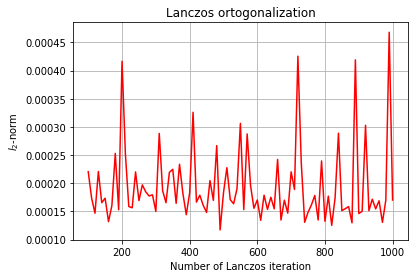

In [43]:
from matplotlib import pyplot as plt
plt.title('Lanczos ortogonalization')
plt.plot(tt,dd,label='red',color='red')
plt.xlabel('Number of Lanczos iteration')
plt.ylabel('$l_2$-norm')
plt.grid(True)
#plt.show()
plt.savefig('Lanczos ortogonalization')